Data preprocessing for GTSRB

In [1]:
data_root = "../data/GTSRB/"

In [2]:
import scipy

In [3]:
scipy.__version__

'1.3.1'

In [4]:
from imageio import imread

In [5]:
img = imread("../data/GTSRB/Final_Training/Images/00031/00015_00010.ppm")

In [6]:
img.shape

(45, 48, 3)

In [7]:
import glob

In [8]:
all_img = glob.glob("../data/GTSRB/Final_Training/Images/*/*.ppm")

In [9]:
print("all images: ", len(all_img))

all images:  39209


In [10]:
%%time

x_size = []
y_size = []

for elem in all_img:
    img_shape = imread(elem).shape
    x_size.append(img_shape[0])
    y_size.append(img_shape[1])

CPU times: user 56.8 s, sys: 53.8 s, total: 1min 50s
Wall time: 12min 44s


In [11]:
import pandas as pd
import matplotlib.pyplot as plt

In [12]:
df = pd.DataFrame({"x" : x_size, "y" : y_size})

(array([2.0864e+04, 1.1268e+04, 3.7100e+03, 1.7520e+03, 9.6600e+02,
        3.9700e+02, 1.5500e+02, 6.8000e+01, 2.3000e+01, 6.0000e+00]),
 array([ 25.,  45.,  65.,  85., 105., 125., 145., 165., 185., 205., 225.]),
 <a list of 10 Patch objects>)

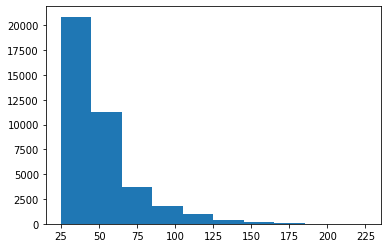

In [13]:
plt.hist(df["x"])

(array([2.2383e+04, 1.0140e+04, 3.7070e+03, 1.7250e+03, 6.7900e+02,
        3.6100e+02, 1.3600e+02, 5.1000e+01, 2.0000e+01, 7.0000e+00]),
 array([ 25. ,  46.8,  68.6,  90.4, 112.2, 134. , 155.8, 177.6, 199.4,
        221.2, 243. ]),
 <a list of 10 Patch objects>)

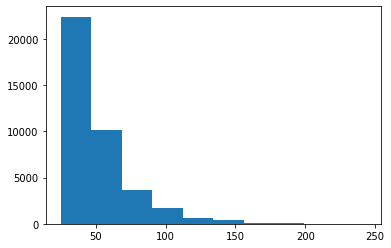

In [14]:
plt.hist(df["y"])

In [15]:
print(sum(x_size) / len(x_size))
print(sum(y_size) / len(y_size))

50.328929582493814
50.83587951745773


Resize all images as [50, 50, 3].

In [16]:
import os

In [17]:
processed_data_root = "../data/GTSRB_processed"

In [18]:
os.makedirs(processed_data_root, exist_ok=True)

In [19]:
categories = list(map(lambda x: x.split("/")[-1], glob.glob("../data/GTSRB/Final_Training/Images/*")))

In [20]:
for cat in categories:
    os.makedirs(f"{processed_data_root}/train/{cat}", exist_ok=True)
    os.makedirs(f"{processed_data_root}/test/{cat}", exist_ok=True)

Now 

```
data/GSTRB_processed/
  - train/
    - 00000/
    - 00001/
    ...
  - test/
    - 00000/
    - 00001/
    ...
```

Preprocess train data.

In [21]:
from PIL import Image
import time
import profile
from concurrent.futures import ProcessPoolExecutor as PPE
import random

In [22]:
all_img = glob.glob("../data/GTSRB/Final_Training/Images/*/*.ppm")

In [23]:
def resize_and_save_img(img_path):
    save_root = "../data/GTSRB_processed"

    # Resize
    img_resized = Image.open(img_path).resize((50, 50))
    # Create save path
    category = img_path.split("/")[-2]
    filename = img_path.split("/")[-1].split(".ppm")[0]
    save_path = f"{save_root}/train/{category}/{filename}.png"
    # Save
    img_resized.save(save_path)

In [24]:
start = time.time()

with PPE(max_workers=8) as exe:
    exe.map(resize_and_save_img, all_img)

elapsed = time.time() - start
print(f"Time: {elapsed}[sec]")

Time: 483.2061560153961[sec]


Preprocess and save test data.

In [25]:
GT_df = pd.read_csv("../data/GTSRB/Final_Test/Images/GT-final_test.test.csv", sep=";")

In [26]:
GT_df.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2
0,00000.ppm,53,54,6,5,48,49
1,00001.ppm,42,45,5,5,36,40
2,00002.ppm,48,52,6,6,43,47
3,00003.ppm,27,29,5,5,22,24
4,00004.ppm,60,57,5,5,55,52


####  Labels for the test set are not published !!

Split train data into train and test.

In [27]:
import random
import shutil

random.seed(23)

In [28]:
def split_img(cat):
    all_img = glob.glob(f"../data/GTSRB_processed/train/{cat}/*.png")
    random.shuffle(all_img)

    test_img = all_img[:len(all_img) // 5]
    for img_path in test_img:
        file = img_path.split("/")[-1]
        save_path = f"../data/GTSRB_processed/test/{cat}/{file}"
        shutil.move(img_path, save_path)

In [29]:
categories = list(map(lambda x: x.split("/")[-1], glob.glob("../data/GTSRB/Final_Training/Images/*")))

In [30]:
start = time.time()

with PPE(max_workers=8) as exe:
    exe.map(split_img, categories)

elapsed = time.time() - start
print(f"Time: {elapsed}[sec]")

Time: 64.327139377594[sec]


In [31]:
print("train num: ", len(glob.glob(f"../data/GTSRB_processed/train/*/*.png")))
print("test num: ", len(glob.glob(f"../data/GTSRB_processed/test/*/*.png")))

train num:  31368
test num:  7841


## Trial and Errors

In [ ]:
import time
import profile
from concurrent.futures import ProcessPoolExecutor as PPE
import random
def calc(x):
    r = 0
    for i in range(10**7):
        if random.random() < 0.99:
            r += i % x
    return r

def main():
    with PPE(max_workers=16) as exe:
        r = [r for r in exe.map(calc, list(range(1, 16)))]
    print(r)

start = time.time()
main()
elapsed = time.time() - start
print(elapsed)